In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
from scipy.integrate import quad
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import copy
import calendar
from optimise_GDD_fctns import * #Phenology_set, run_GDD_and_get_RMSE, run_GDD_and_get_RMSE_derivs, plot_profiles_at_minimum, get_station_locations, put_ERA5_in_array

#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\optimisation_experiments\optimise_GDD_fctns.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [2]:
def local_opt(x1s, train, test, error_fctn = run_GDD_and_get_RMSE, lower_bounds = [0.05, 4, 20, 20, 35], upper_bounds = [1, 12, 35, 35, 60], #ds
              great_threshold = 13, response_type = 'Trapezoid', phase_list = ['yellow ripeness'],
              method = 'trust-constr', modified_cost = False, thresholds = [100], growing_period_length = 185,
              maxiter = 50, split = True, CCNN_split = False, test_size = 0.5, random_state=1, itr = 0.5, bias_term = False):
    #if split:
    #    train, test = train_test_split(ds, test_size=test_size, random_state = random_state)
    #    #train_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_training.csv')
    #elif CCNN_split:
    #    test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_results.csv')
    #    train_indices = train_indices.rename(columns = {'year': 'Referenzjahr'})
    #    test_indices = test_indices.rename(columns = {'year': 'Referenzjahr'})
    #    test = pd.merge(ds, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #    complement_indices = ds.index.difference(test.index)
    #
    #    # Filter df2 to keep only the rows with the complement indices
    #    train = ds.loc[complement_indices]
    #    #train = pd.merge(ds, train_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #    test = pd.merge(ds, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #else:
    #    train = ds
    #    test = ds
    only_phase = phase_list[0]
    if response_type == 'Trapezoid':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2],
                                                x[4] - x[3]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0, 0],
                                                [0, 0, -1, 1, 0],
                                                [0, 0, 0, -1, 1]])}
        constraints = scipy.optimize.LinearConstraint([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0], [0, 0, 0, -1, -1]], [0, 0, 0], [np.inf, np.inf, np.inf])
    elif response_type == 'Wang' or response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        if bias_term:
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0]]),lb= [0, 0], ub=[1000, 1000])
        else:  
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0], [0, 0, -1, 1]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0, 0], [0, 0, -1, 1, 0, 0]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Spline':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2],
                                                x[3]]),
                    'jac' : lambda x: np.array([[0 for count in range(20)],
                                                [0 for count in range(20)]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0 for count in range(20)], [0 for count in range(20)]]),lb= [-1, -1], ub=[1000, 1000])
    bounds = scipy.optimize.Bounds(lb=lower_bounds, ub = upper_bounds)
    x0 = np.array([1, 4, 25, 35, 45])
    final_mins = []
    for x0 in x1s:
        if method == 'trust-constr':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list, 
                                                                         new_unfinished_penalisation=modified_cost, 
                                                                         growing_period_length = growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'trust-constr',#'COBYQA',
                                    jac='3-point',#
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', #jac='3-point',#[x0/1000 for x0 in 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#
                                    constraints=[constraints],
                                    options={'verbose': 3, 'initial_tr_radius': itr, 'xtol':1e-7, 'maxiter':maxiter},# ,'gtol':1e-7, 'finite_diff_rel_step': 0.05
                                    bounds=bounds, tol=1e-9)
        elif method == 'SLSQP':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'SLSQP',
                                    #jac = '3-point',
                                    jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                                                                response_type = response_type, 
                                                                                phase_list = phase_list, 
                                                                                growing_period_length=growing_period_length,
                                                                                thresholds = thresholds),#jac='3-point',#
                                    constraints=[ineq_cons],
                                    options={'disp': 3, 'maxiter':maxiter, 'ftol': 1e-16},
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Nelder-Mead':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Nelder-Mead',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Powell':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Powell',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)
        print(x0, res.x, x0 - res.x)
        RMSE = error_fctn(res.x, test, 't2m', response_type = response_type, phase_list = phase_list, thresholds = thresholds)
        #print('R^2: ', r2_score(c_array[f'observed time to {only_phase}'], c_array[f'modelled time to {only_phase}']))
        print('RMSE at opt on test set: ', RMSE)
        print('R^2:', 1 - (RMSE**2/(test[f'observed time to {only_phase}'].var()*((len(test) - 1)/len(test)))))
        final_mins.append(res.x)
    return final_mins, res, train, test

In [3]:
def KFold_crossval(ds, k_folds, method = 'Nelder-Mead'):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    RMSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    statyear = ds[['Stations_id', 'Referenzjahr']].drop_duplicates()

    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner')

        x1s = [np.array([0.5, 8, 28, 39])]
        print(f'Fold {fold + 1}')
        fm = local_opt(x1s, train, 
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method=method,
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.02)
        print('Parameters: ', fm)

        comparison_array = run_GDD_and_plot(fm[0][0], test, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='Full set', method = 'regression')
        comparison_array['Error'] = comparison_array['observed time to beginning of flowering'] - comparison_array['modelled time to beginning of flowering']

        r2_score_model = r2_score(comparison_array['observed time to beginning of flowering'], comparison_array['modelled time to beginning of flowering'])
        bias_model = (comparison_array['Error']).mean()
        variance = comparison_array['modelled time to beginning of flowering'].var()

        RMSE = np.sqrt(np.mean((comparison_array['Error'] - bias_model)**2))
        STD = comparison_array['modelled time to beginning of flowering'].std() 
        Corr = comparison_array['observed time to beginning of flowering'].corr(comparison_array['modelled time to beginning of flowering'])

        RMSEs.append(RMSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_array['Error'].min())
        LQs.append(comparison_array['Error'].quantile(0.25))
        Medians.append(comparison_array['Error'].median())
        UQs.append(comparison_array['Error'].quantile(0.75))
        Maxs.append(comparison_array['Error'].max())

        R2s.append(r2_score_model)
        Biases.append(bias_model)
        Variances.append(variance)

        print(f'Fold: {fold + 1}\nR2: {r2_score_model}\nBias: {bias_model}\nVariance: {variance}')
    print(f'Average score: {np.mean(R2s)}')
    return R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs

In [4]:
def make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, model, region, eval_method):
    error_df = pd.DataFrame({
        'model': [model],
        'region': [region],
        'evaluation method': [eval_method],
        'R2': [np.mean(R2s)],
        'Bias (obs minus modelled)': [np.mean(Biases)],
        'Variance': [np.mean(Variances)],
        'RMSE': [np.mean(RMSEs)],
        'STD': [np.mean(STDs)],
        'Corr': [np.mean(Corrs)],
        'Min': [np.mean(Mins)],
        'LQ': [np.mean(LQs)],
        'Median': [np.mean(Medians)],
        'UQ': [np.mean(UQs)],
        'Max': [np.mean(Maxs)]
    })
    return error_df

In [5]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5.csv')
for vble in ['photoperiod', 'DTF', 'dev stage', 'vpd', 'ssrd', 't2max', 't2min', 'tp']:
    ds_inputs_DE = ds_inputs_DE.drop(columns = [col for col in ds_inputs_DE.columns if vble in col])

In [ ]:
cf_stoch = stoch_GDD_simulation(fm_flowering_all_DE2[0][0], ds_inputs_DE, 'temperature', response_type='Wang', phase_list = ['beginning of flowering'],
                                thresholds = [20], growing_period_length=300, scale_param=1)

In [ ]:
modelled_time = cf_stoch['modelled time to flowering']
for count in range(20):
    print(count)
    cf_stoch_new = stoch_GDD_simulation(fm_flowering_all_DE2[0][0], ds_inputs_DE, 'temperature', response_type='Wang', phase_list = ['beginning of flowering'],
                                thresholds = [20], growing_period_length=300, scale_param=1)
    modelled_time += cf_stoch_new['modelled time to flowering']
modelled_time /= 21


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
cf_stoch['Meaned modelled time to flowering'] = modelled_time
cf_stoch['Meaned Error'] = cf_stoch['Meaned modelled time to flowering'] - cf_stoch['observed time to beginning of flowering']

In [ ]:
cf_stoch['Error'] = cf_stoch['observed time to beginning of flowering'] - cf_stoch['modelled time to flowering']

In [ ]:
np.sqrt((cf_stoch['Meaned Error']**2).mean())

np.float64(10.09899455227818)

<Axes: xlabel='Meaned modelled time to flowering', ylabel='Meaned Error'>

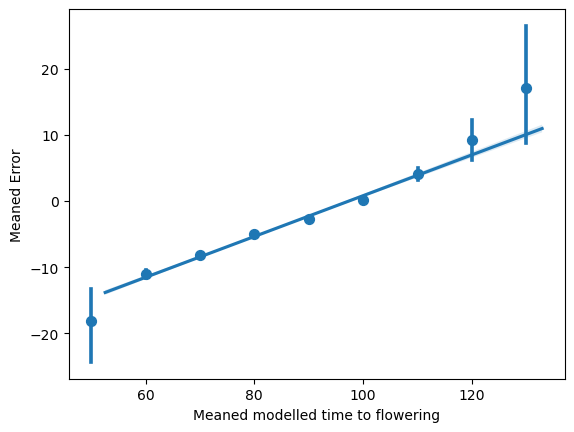

In [ ]:
sns.regplot(x='Meaned modelled time to flowering', y='Meaned Error', data=cf_stoch, x_bins = np.arange(0, 150, 10))

<Axes: xlabel='Meaned modelled time to flowering', ylabel='observed time to beginning of flowering'>

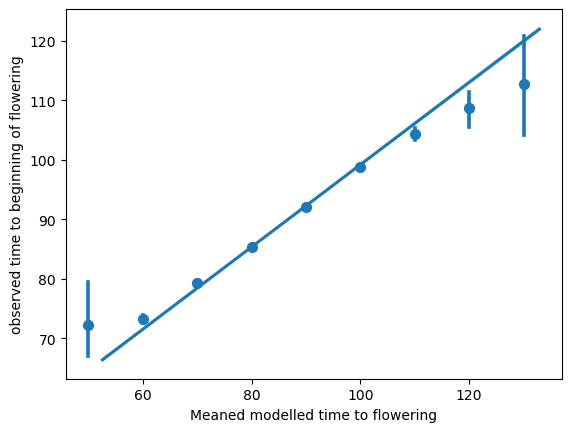

In [ ]:
sns.regplot(x='Meaned modelled time to flowering', y='observed time to beginning of flowering', data=cf_stoch, x_bins = np.arange(0, 150, 10))

((array([-10.54031968,  -9.65348893,  -9.18698236, ...,   9.18698236,
           9.65348893,  10.54031968], shape=(26208,)),
  array([ 51,  53,  55, ..., 131, 133, 133], shape=(26208,))),
 (np.float64(5.468003903793307),
  np.float64(83.31944444444444),
  np.float64(0.9942383391364268)))

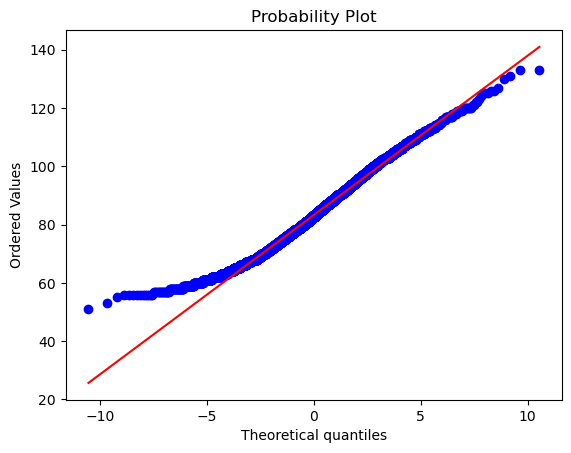

In [ ]:
stats.probplot(cf_stoch['modelled time to flowering'], dist=scipy.stats.logistic, plot=plt)# #gennorm(beta = 1.5)

In [ ]:
cf2 = run_GDD(fm_flowering_all_DE4[0][0], fm_flowering_all_DE4[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

In [ ]:
cf4 = run_GDD_transformed_space(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [3])

In [ ]:
cf4['modelled GDD at beginning of flowering'].var()

9.802791223594378

In [ ]:
cf4['modelled GDD at beginning of flowering'].mean()

np.float64(21.39304488888339)

In [ ]:
cf_convolved = run_GDD(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],# + [3, 7.5]
                               't2m', response_type='Convolved', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

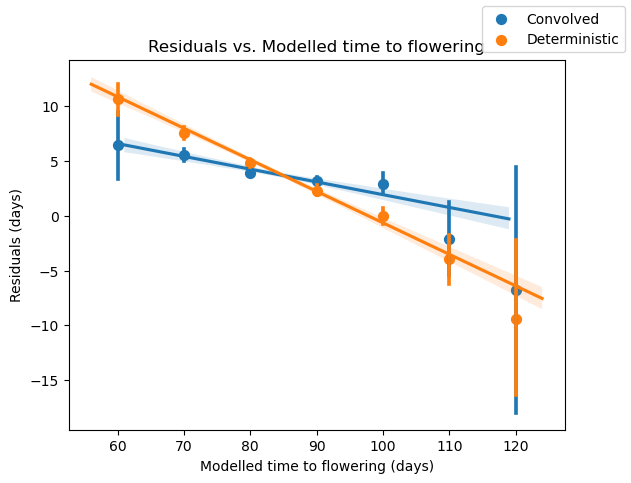

In [ ]:
cf_convolved['Error'] = cf_convolved['observed time to beginning of flowering'] - cf_convolved['modelled time to beginning of flowering']
cf_deterministic['Error'] = cf_deterministic['observed time to beginning of flowering'] - cf_deterministic['modelled time to beginning of flowering']
fig, ax = plt.subplots()
sns.regplot(x='modelled time to beginning of flowering', y='Error', data=cf_convolved, x_bins = np.arange(0, 150, 10), label = 'Convolved', ax=ax)
sns.regplot(x='modelled time to beginning of flowering', y='Error', data=cf_deterministic, x_bins = np.arange(0, 150, 10), label = 'Deterministic', ax=ax)
ax.set_ylabel('Residuals (days)')
ax.set_xlabel('Modelled time to flowering (days)')
ax.set_title('Residuals vs. Modelled time to flowering')
fig.legend()

In [ ]:
params_squashed = [0.380, 7.6, 25, 39]
params_steep = [0.503004, 7.02058042, 27.00252239, 39.30655295]
fm_flowering_all_DE2 = [[[0.503004, 7.02058042, 27.00252239, 39.30655295]], ds_inputs_DE, 0] #_reduced
cf_deterministic = run_GDD(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

Text(0, 0.5, 'Convolved - Standard (days)')

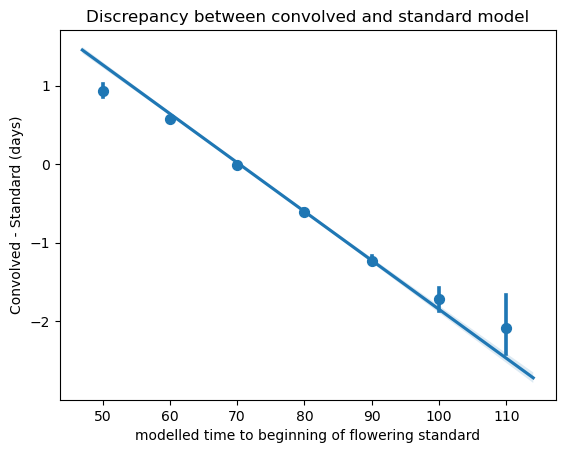

In [ ]:
cf_compare_convolution = cf_deterministic[['year', 'Stations_id', 'observed time to beginning of flowering', 'modelled time to beginning of flowering']].merge(cf_convolved[['year', 'Stations_id', 'modelled time to beginning of flowering']], suffixes = [' standard', ' convolved'], on = ['year', 'Stations_id'])
cf_compare_convolution['discrepancy'] = cf_compare_convolution['modelled time to beginning of flowering convolved'] - cf_compare_convolution['modelled time to beginning of flowering standard']
fig, ax = plt.subplots()
sns.regplot(x = 'modelled time to beginning of flowering standard', y = 'discrepancy', data = cf_compare_convolution, x_bins = np.arange(0, 150, 10), ax=ax)
ax.set_title('Discrepancy between convolved and standard model')
ax.set_ylabel('Convolved - Standard (days)')

In [ ]:
cf_stoch = stoch_GDD_simulation(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2], 't2m', response_type='Convolved', phase_list = ['beginning of flowering'],
                                thresholds = [20], growing_period_length=300, scale_param=1)
cf_stoch['modelled time to flowering mean'] = cf_stoch['modelled time to flowering']

In [ ]:
for sample_index in range(50):
    print(sample_index)
    cf_stoch_new = stoch_GDD_simulation(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2], 't2m', response_type='Convolved', phase_list = ['beginning of flowering'],
                                thresholds = [20], growing_period_length=300, scale_param=1)
    cf_stoch['modelled time to flowering mean'] += cf_stoch_new['modelled time to flowering']
cf_stoch['modelled time to flowering mean'] /= 101

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
cf_stoch['modelled time to flowering mean'] =  cf_stoch['modelled time to flowering mean']*101/51

In [46]:
def GDD_rate_mean(x, ds, vble, std_dev = 0.01, response_type='Wang', phase_list = ['beginning of flowering'],
                  thresholds = [20], growing_period_length=300, n_samples=100):
    mean = x[0]        # Mean of the normal distribution
    y = np.arange(0.2, 1, 1/n_samples)[1:]
    rates = norm.ppf(y, loc=mean, scale=std_dev)
    cf = run_GDD(x, ds, vble, response_type=response_type, phase_list=phase_list,
                  thresholds=thresholds, growing_period_length=growing_period_length)
    for ind, rate in enumerate(rates):
        if ind % 20 == 0:
            print(ind)
        cf_new = run_GDD([rate] + x[1:], ds, vble, response_type=response_type, phase_list=phase_list,
                  thresholds=thresholds, growing_period_length=growing_period_length)
        cf.loc[:, 'modelled time to ' + phase_list[0] + f' sample {ind}'] = cf_new.loc[:, 'modelled time to ' + phase_list[0]]
    return cf

In [56]:
params_squashed = [0.380, 7.6, 25, 39]
params_steep = [0.503004, 7.02058042, 27.00252239, 39.30655295]
ds_inputs_DE_reduced = ds_inputs_DE.sample(frac = 0.2, random_state=1)
cf_squashed = GDD_rate_mean(params_squashed, ds_inputs_DE_reduced,# + [3, 7.5]
                               't2m', std_dev = 0.1, response_type='Wang', phase_list = ['beginning of flowering'], growing_period_length=300,
                               thresholds = [20])
cf_steep = GDD_rate_mean(params_steep, ds_inputs_DE_reduced,# + [3, 7.5]
                               't2m', std_dev = 0.1, response_type='Wang', phase_list = ['beginning of flowering'], growing_period_length=300,
                                 thresholds = [20])

0
20
40
60
0
20
40
60


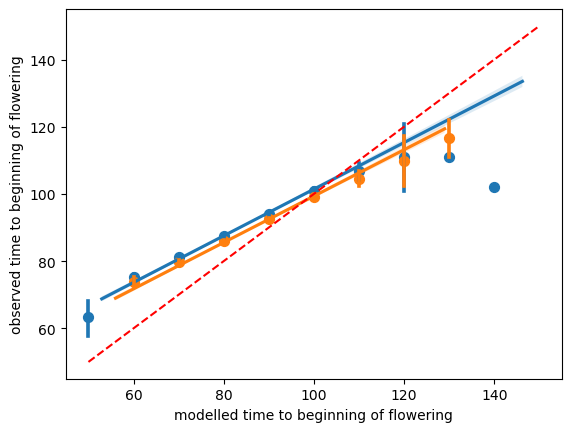

In [57]:
cf_steep['modelled time to beginning of flowering mean'] = cf_steep[[f'modelled time to beginning of flowering sample {count}' for count in range(79)]].mean(axis=1)#99
cf_steep['discrepancy'] = cf_steep['modelled time to beginning of flowering'] - cf_steep['modelled time to beginning of flowering mean']
fig, ax = plt.subplots()
sns.regplot(x = 'modelled time to beginning of flowering mean', y = 'observed time to beginning of flowering', data = cf_steep, x_bins = np.arange(50, 150, 10))
sns.regplot(x = 'modelled time to beginning of flowering', y = 'observed time to beginning of flowering', data = cf_steep, x_bins = np.arange(50, 150, 10))
ax.plot([50, 150], [50, 150], color = 'red', linestyle = '--')

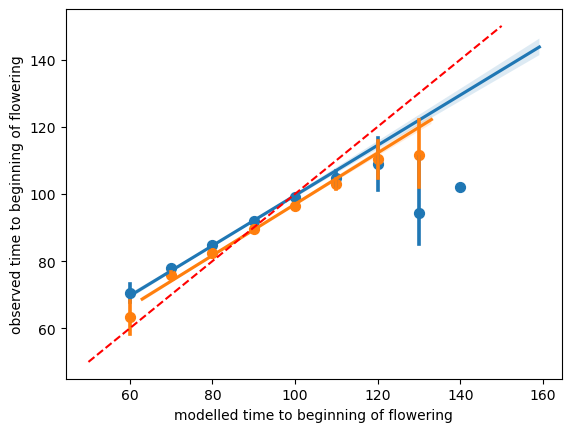

In [58]:
cf_squashed['modelled time to beginning of flowering mean'] = cf_squashed[[f'modelled time to beginning of flowering sample {count}' for count in range(79)]].mean(axis=1)
cf_squashed['discrepancy'] = cf_squashed['modelled time to beginning of flowering'] - cf_squashed['modelled time to beginning of flowering mean']
fig, ax = plt.subplots()
sns.regplot(x = 'modelled time to beginning of flowering mean', y = 'observed time to beginning of flowering', data = cf_squashed, x_bins = np.arange(50, 150, 10))#, fit_reg=False)
sns.regplot(x = 'modelled time to beginning of flowering', y = 'observed time to beginning of flowering', data = cf_squashed, x_bins = np.arange(50, 150, 10))#, fit_reg=False)
ax.plot([50, 150], [50, 150], color = 'red', linestyle = '--')

In [ ]:
y = np.arange(0, 1, 0.01)[1:]
s = np.sqrt(0.5 * 3 / np.pi**2)
mu = 0
log_distributed = mu + s * np.log(y / (1 - y))
cfs = []
for pert in log_distributed:
    print(pert)
    ds_inputs_shifted = ds_inputs_DE_reduced.copy()
    ds_inputs_shifted[[f't2m at day {n}' for n in range(300)]] += pert
    cf_for_list = run_GDD(fm_flowering_all_DE2[0][0], ds_inputs_shifted,
                               't2m', response_type='Convolved', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])
    cfs.append(cf_for_list)

-1.7914001242176545
-1.5172199187065736
-1.3551515146185675
-1.2389592028353624
-1.1478848267419122
-1.0726816410301545
-1.0084167036892007
-0.9521450854899604
-0.9019668767523202
-0.856584487270533
-0.8150720727435236
-0.7767457130452202
-0.7410857326896751
-0.7076878901497148
-0.6762314471513327
-0.6464575635218227
-0.6181542527436411
-0.5911456435095072
-0.5652841477991541
-0.5404446394667307
-0.5165200538743928
-0.49341801135771174
-0.4710581910770825
-0.4493702633732803
-0.42829224363526663
-0.4077691683334757
-0.38775202013731336
-0.36819684765061156
-0.34906403868216157
-0.33031771571802027
-0.31192522945137113
-0.2938567315865031
-0.27608481217260356
-0.2585841897957887
-0.24133144531627965
-0.22430479166292822
-0.2074838736207777
-0.19084959266530893
-0.17438395278069305
-0.1580699239019012
-0.14189132018187448
-0.1258326907354218
-0.10987922087417722
-0.09401664213953086
-0.07823114967658824
-0.06250932568247401
-0.046838067814838985
-0.031204521567569313
-0.01559601571529208

In [ ]:
cf_spread = cfs[0][['year', 'Stations_id', 'modelled time to beginning of flowering']]
cf_spread = cf_spread.rename(columns = {'modelled time to beginning of flowering': 'modelled time to beginning of flowering pert 0'})
for i, cf_for_list in enumerate(cfs):
    cf_spread = pd.merge(cf_spread, cf_for_list[['year', 'Stations_id', 'modelled time to beginning of flowering']], on=['year', 'Stations_id'])
    cf_spread = cf_spread.rename(columns = {'modelled time to beginning of flowering': f'modelled time to beginning of flowering pert {i + 1}'})
print(len(cf_spread))
cf_spread = cf_spread.loc[cf_spread['modelled time to beginning of flowering pert 0'] < 300]#cf_spread.columns[-1]
print(len(cf_spread))
cf_spread.loc[:, 'modelled time to beginning of flowering mean'] = cf_spread[[f'modelled time to beginning of flowering pert {i}' for i in range(len(cfs))]].mean(axis=1)
cf_spread = cf_spread.merge(cf_deterministic[['year', 'Stations_id', 'modelled time to beginning of flowering', 'observed time to beginning of flowering']], on = ['year', 'Stations_id'])
cf_spread['discrepancy'] = cf_spread['modelled time to beginning of flowering mean'] - cf_spread['modelled time to beginning of flowering']
cf_spread['Error'] = cf_spread['observed time to beginning of flowering'] - cf_spread['modelled time to beginning of flowering mean']
cf_deterministic['Error'] = cf_deterministic['observed time to beginning of flowering'] - cf_deterministic['modelled time to beginning of flowering']

5242
5234


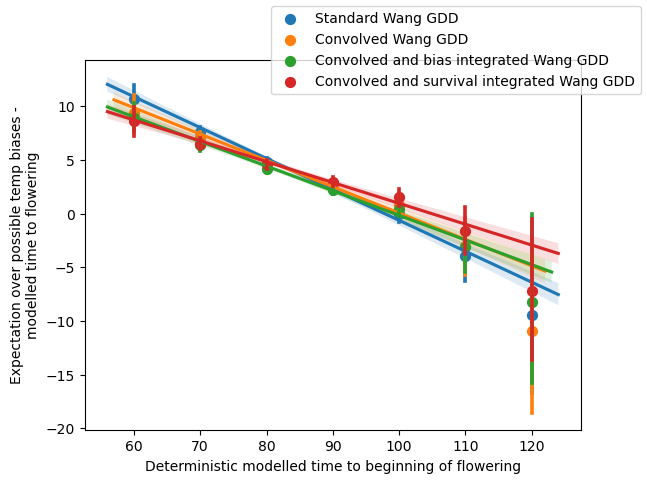

In [ ]:
fig, ax = plt.subplots()
cf_deterministic['Error'] = cf_deterministic['observed time to beginning of flowering'] - cf_deterministic['modelled time to beginning of flowering']
sns.regplot(x='modelled time to beginning of flowering', y='Error', data=cf_deterministic, x_bins = np.arange(0, 150, 10), ax = ax, label = 'Standard Wang GDD')
sns.regplot(x='modelled time to beginning of flowering', y='Error', data=cf_convolved, x_bins = np.arange(0, 150, 10), ax = ax, label = 'Convolved Wang GDD')
sns.regplot(x='modelled time to beginning of flowering', y='Error', data=cf_spread, x_bins = np.arange(0, 150, 10), ax = ax, label = 'Convolved and bias integrated Wang GDD')
sns.regplot(x='Deterministic modelled time to beginning of flowering', y='Error', data=cf_compare, x_bins = np.arange(0, 150, 10), ax = ax, label = 'Convolved and survival integrated Wang GDD')
ax.set_ylabel('Expectation over possible temp biases -\nmodelled time to flowering')
fig.legend()

In [ ]:
print(cf_deterministic['modelled time to beginning of flowering'].var(), cf_stoch['modelled time to flowering'].var(),
      cf_stoch['modelled time to flowering mean'].var())

81.37360327229229 112.9177061296043 81.10227794629516


In [ ]:
cf_compare = cf_stoch.merge(cf_deterministic[['modelled time to beginning of flowering', 'Stations_id', 'year']], on = ['Stations_id', 'year'])
cf_compare = cf_compare.rename(columns = {'modelled time to flowering': 'Stochastic modelled time to beginning of flowering',
                                        'modelled time to flowering mean': 'Meaned stochastic modelled time to beginning of flowering',
                                        'modelled time to beginning of flowering': 'Deterministic modelled time to beginning of flowering'})

In [ ]:
cf_compare['sample discrepancy'] = cf_compare['Stochastic modelled time to beginning of flowering'] - cf_compare['Deterministic modelled time to beginning of flowering']
cf_compare['mean discrepancy'] = cf_compare['Meaned stochastic modelled time to beginning of flowering'] - cf_compare['Deterministic modelled time to beginning of flowering']

In [ ]:
cf_compare['Error'] = cf_compare['observed time to beginning of flowering'] - cf_compare['Meaned stochastic modelled time to beginning of flowering']

<Axes: xlabel='Deterministic modelled time to beginning of flowering', ylabel='mean discrepancy'>

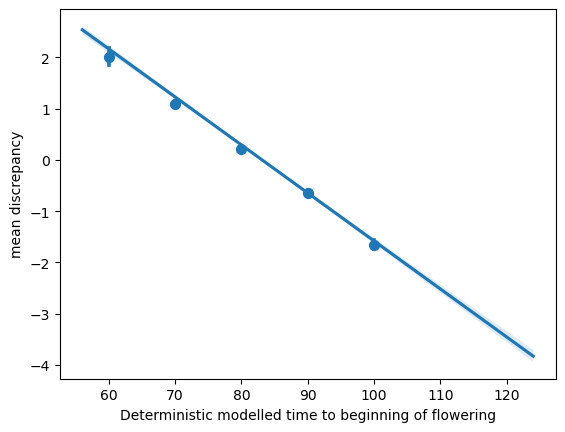

In [ ]:
sns.regplot(x='Deterministic modelled time to beginning of flowering', y='mean discrepancy', data=cf_compare, x_bins = np.arange(0, 110, 10))

<Axes: xlabel='sample discrepancy', ylabel='Count'>

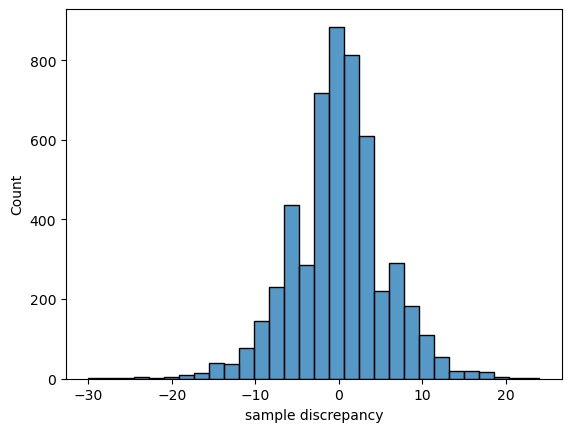

In [ ]:
sns.histplot(cf_compare['sample discrepancy'], bins = 30)

In [ ]:
fm_flowering_all_DE2 = [[[0.503004, 7.02058042, 27.00252239, 39.30655295]], ds_inputs_DE, 0]
cf3 = run_GDD(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],
                               't2m', response_type='Convolved', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

In [ ]:
cf5 = run_GDD(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

<Axes: xlabel='modelled time to beginning of flowering', ylabel='Count'>

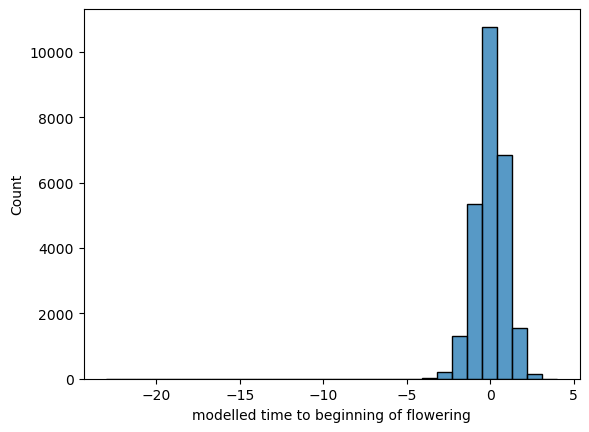

In [ ]:
sns.histplot(cf3['modelled time to beginning of flowering'] - cf5['modelled time to beginning of flowering'], bins=30)

In [ ]:
y = np.arange(0, 1, 0.01)[1:]
s = np.sqrt(cf4['modelled GDD at beginning of flowering'].var() * 3 / np.pi**2)
mu = cf4['modelled GDD at beginning of flowering'].mean()
log_distributed = mu + s * np.log(y / (1 - y))
cfs = []
for threshold in log_distributed:
    print(threshold)
    cf_for_list = run_GDD(fm_flowering_all_DE2[0][0], fm_flowering_all_DE2[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [threshold])
    cfs.append(cf_for_list)

13.461049109093125
14.675069474289707
15.392679057924646
15.907157601410823
16.310418468178806
16.643404574201853
16.92795809459393
17.17711864339833
17.399298677084673
17.60024369041805
17.784053154526998
17.953755344044502
18.111651288040328
18.25953089489073
18.398814335668288
18.530647707847145
18.655969649389753
18.775558886638866
18.8900689126573
19.000053763390127
19.105987501691352
19.20827916800843
19.307284408493317
19.403314630158107
19.49664428965072
19.587516755540058
19.676149067701328
19.76273583496826
19.847452452959764
19.930457780819218
20.011896383772662
20.091900424675515
20.17059126983295
20.24808086077357
20.324472893213017
20.3998638363622
20.47434381943176
20.547997407234345
20.620904282873507
20.693139852397355
20.76477578380949
20.835880490835294
20.90651957023564
20.976756200164843
21.046651506023803
21.116264899417075
21.185654395147054
21.25487691064211
21.32398855179663
21.39304488888339
21.46210122597015
21.531212867124673
21.60043538261973
21.66982487834

In [ ]:
cf_spread = cfs[0][['Referenzjahr', 'Stations_id', 'modelled time to beginning of flowering']]
cf_spread = cf_spread.rename(columns = {'modelled time to beginning of flowering': 'modelled time to beginning of flowering threshold 0'})
for i, cf_for_list in enumerate(cfs):
    cf_spread = pd.merge(cf_spread, cf_for_list[['Referenzjahr', 'Stations_id', 'modelled time to beginning of flowering']], on=['Referenzjahr', 'Stations_id'])
    cf_spread = cf_spread.rename(columns = {'modelled time to beginning of flowering': f'modelled time to beginning of flowering threshold {i + 1}'})
print(len(cf_spread))
cf_spread = cf_spread.loc[cf_spread['modelled time to beginning of flowering threshold 0'] < 300]#cf_spread.columns[-1]
print(len(cf_spread))
cf_spread.loc[:, 'modelled time to beginning of flowering mean'] = cf_spread[[f'modelled time to beginning of flowering threshold {i}' for i in range(len(cfs))]].mean(axis=1)

In [ ]:
cf_spread.loc[:, 'discrepancy'] = cf_spread['modelled time to beginning of flowering mean'] - cf_spread['modelled time to beginning of flowering threshold 9']

In [ ]:
cf_spread = cf_spread.merge(ds_inputs_DE[['Referenzjahr', 'Stations_id', 'observed time to beginning of flowering']], on=['Referenzjahr', 'Stations_id'], how='inner')

In [ ]:
np.sqrt(((cf_spread['modelled time to beginning of flowering mean'] - cf_spread['observed time to beginning of flowering'])**2).mean())

np.float64(9.147363930735544)

In [ ]:
cf_spread['modelled time to beginning of flowering mean'].max()

138.94736842105263

<Axes: xlabel='discrepancy', ylabel='Count'>

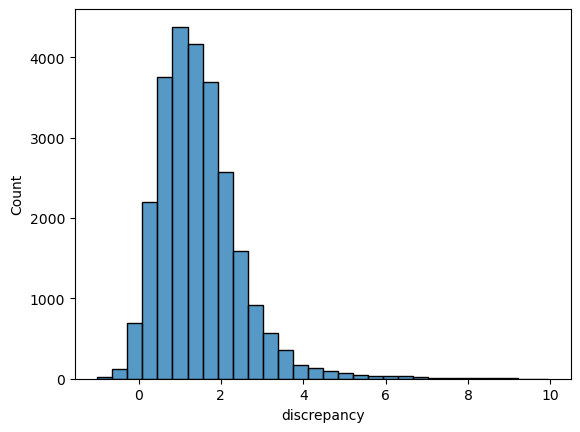

In [ ]:
sns.histplot(cf_spread['discrepancy'], bins = 30)

((array([-13.36836075, -12.48156486, -12.01509419, ...,  12.01509419,
          12.48156486,  13.36836075], shape=(443232,)),
  array([ 47.,  48.,  48., ..., 238., 248., 248.], shape=(443232,))),
 (np.float64(9.239586702686301),
  np.float64(87.26630748682406),
  np.float64(0.9757340151492986)))

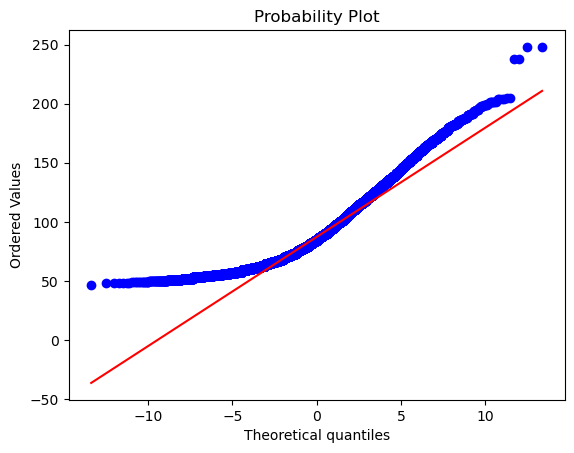

In [ ]:
stats.probplot(cf_spread[[f'modelled time to beginning of flowering threshold {i}' for i in range(len(cfs))]].values.flatten(), dist=scipy.stats.logistic, plot=plt)# #gennorm(beta = 1.5)

<Axes: xlabel='modelled time to flowering', ylabel='Count'>

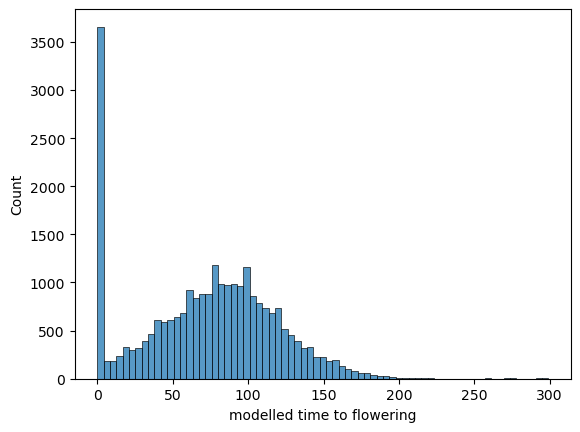

In [ ]:
sns.histplot(cf_stoch['modelled time to flowering'])

((array([-10.5213292 ,  -9.63449774,  -9.16799044, ...,   9.16799044,
           9.63449774,  10.5213292 ], shape=(25715,)),
  array([ 37.07737839,  37.31415484,  37.81230248, ..., 148.06181501,
         151.94675909, 152.14866914], shape=(25715,))),
 (np.float64(7.3674578025232496),
  np.float64(86.62164955235231),
  np.float64(0.9979111415000055)))

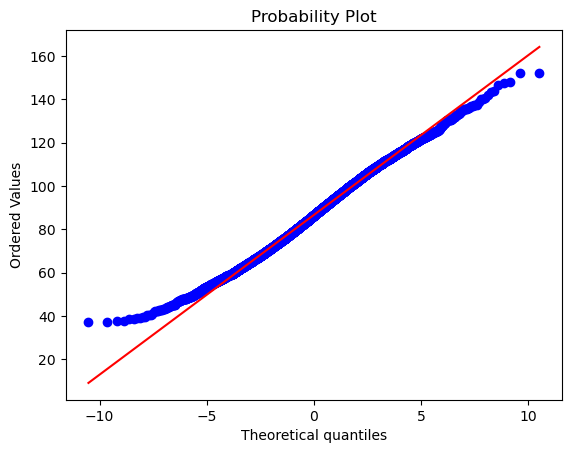

In [ ]:
stats.probplot(cf_spread['modelled time to beginning of flowering mean'] + np.random.logistic(0, 5, len(cf_spread)), dist=scipy.stats.logistic, plot=plt)# #gennorm(beta = 1.5)

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

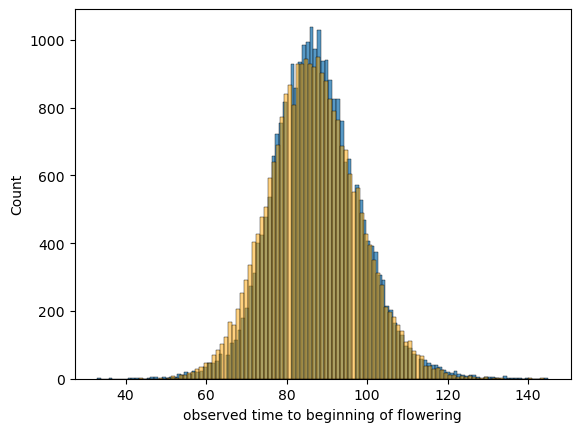

In [ ]:
fig, ax = plt.subplots()
sns.histplot(cf_spread['observed time to beginning of flowering'], ax=ax)
sns.histplot(cf_spread['modelled time to beginning of flowering mean'] + np.random.normal(0, 5, len(cf_spread)), ax=ax, color='orange', alpha=0.5)

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

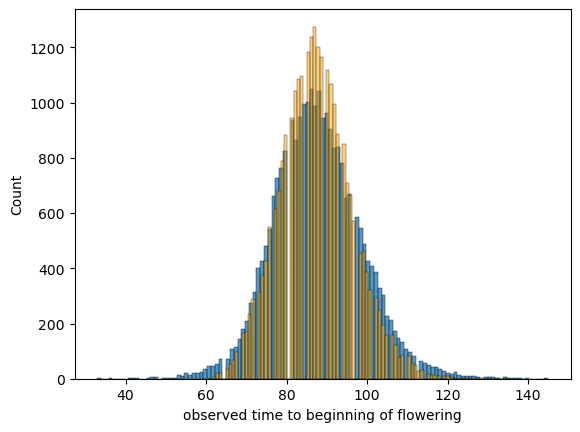

In [ ]:
fig, ax = plt.subplots()
sns.histplot(cf3['observed time to beginning of flowering'], ax=ax)
sns.histplot(cf3['modelled time to beginning of flowering'] + 3, ax=ax, color='orange', alpha=0.5)